<a href="https://www.kaggle.com/code/ayushs9020/understanding-the-competition-icr-eda?scriptVersionId=129395845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICR Identify Age Related Conditions 

$ICR$, or $Identify$ $Age$ $Related$ $Conditions$, is a process aimed at `detecting and diagnosing health conditions commonly associated with aging`. It involves a `comprehensive evaluation` of an individual's `medical history`, `physical examination`, and `specific tests` to assess their overall health and `identify` any `age-related conditions`. The `goal` is to `catch potential issues early` on, allowing for `timely intervention` and `management of age-related health concerns`. $ICR$ helps healthcare professionals tailor `preventive measures` and `develop personalized` treatment plans to promote `healthy aging`.

# 1 | Important Points 📃
* This is a **`binary classification`** problem where $1$ is for `suffering from a disease` and $0$ is for `not suffering from any disease`.

* * The class $1$ is further divided into $3$ more categoreis, we actually do not know much about the actual names of these categories, but according to the data, these are 

* * * **B**
* * * **D**
* * * **G**

* * Though we are actually not given $1$ or $0$. Rather values like $(A , B , D , G)$

* Using $XGBoost$ and $RandomForestClassifier$ and more of such algorithms, `may give better results`, but might **not be actually benificial for the actual purpose of the competition and research**. As it is written that they have been using these algorithms from the year they were established ie $2015$. Try to come up with something different

# 2 | Advisory 🚀
## Greeks
* `Id` - It is like the primary of the data, you can probably remove that one
* `Alpha` - Change the values corresponding to `A` to $0$ , and rest to be $0$. The data is highly imbalanced, having $(0 -> 82.50)$ and $(1 -> 17.50)$. I recomend using `Random Over Sampling`.

```
from imblearn_oversampling import RandomOverSampler

features , target = RandomOverSampler().fit_resample(features , target)
```

* `Beta` - This is the first experimental characteristic, This further contains $3$ values $(A , B , C)$, but the ratio of $(A)$ is really small, At this point I have decided to assume $(A)$ as $(B)$, but we do not have any actual reason for doing so. $(A -> 1.30, B -> 32.74, C -> 67.96)$
* `Gamma` - This is the second experimental characteristic, This further contains $8$ values $(A , B , E , F , G , H , M , N)$ , but the combined ratio of $(A , B , E , F , G)$ is around $8.92$% , which is just above than their succesor $(H)$ with $8.59$%. Combining these into $1$ might give better performance. $(A ->1.30, B ->1.30, E ->1.62, F ->1.78, G ->2.92, H ->8.59, M ->10.37, N ->72.12)$. At this point I have converted these into $(G)$. There was no particular reason for converting these into $(G)$ only. 
* `Delta` - This is the third experimental characteristic. This further contains $4$ values $(A , B , C , D)$. These are in good condtion with $(A ->73.91, B ->12.16, C ->10.37, D ->3.57)$
* `Epsilon` - Though you can use this `feature` with some preprocessing, but it might not be good to classify someone with a disease on the basis of the date the person came. That is indirectly racism on date!! . 

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


Lets take a look at the datasets now 
# 3 | Greeks 🔠
**Supplemental metadata, only available for the training set**.

In [4]:
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


In [5]:
greeks.drop("Id" , axis = 1 , inplace = True)
greeks

,Alpha,Beta,Gamma,Delta,Epsilon
0,B,C,G,D,3/19/2019
1,A,C,M,B,Unknown
2,A,C,M,B,Unknown
3,A,C,M,B,Unknown
4,D,B,F,B,3/25/2020
...,...,...,...,...,...
612,A,B,M,B,9/13/2020
613,A,B,M,B,9/8/2020
614,A,C,M,B,7/24/2019
615,A,C,M,B,1/31/2019


<AxesSubplot: ylabel='Alpha'>

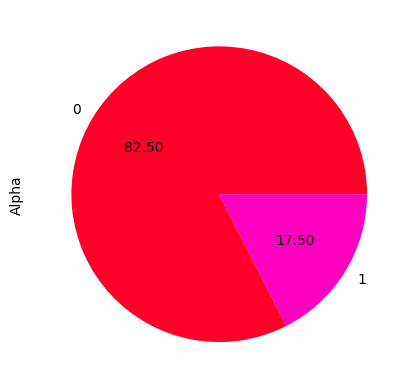

In [6]:
greeks["Alpha"] = np.where(greeks["Alpha"] == "A" , 0 , 1)
greeks["Alpha"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Beta'>

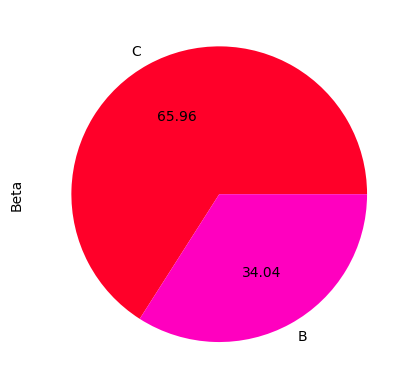

In [7]:
greeks["Beta"] = np.where(greeks["Beta"] == "A" , "B" , greeks["Beta"])
greeks["Beta"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Gamma'>

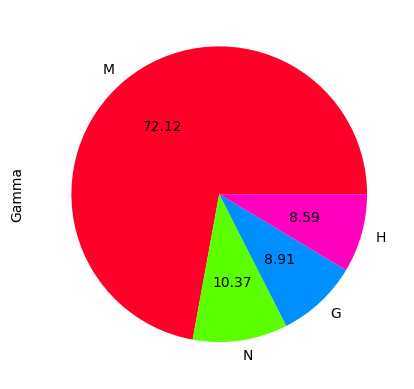

In [8]:
greeks["Gamma"] = np.where(greeks["Gamma"] == "A" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "B" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "E" , "G" , greeks["Gamma"])
greeks["Gamma"] = np.where(greeks["Gamma"] == "F" , "G" , greeks["Gamma"])
greeks["Gamma"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

<AxesSubplot: ylabel='Delta'>

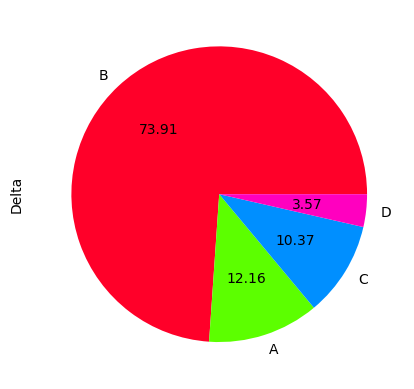

In [9]:
greeks["Delta"].value_counts().plot(kind = "pie" , autopct = "%.2f" , cmap = "gist_rainbow")

# 4 | Train 🚅

In [10]:
train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
train

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


This is how `training data` looks like. We can train different binary classification algorithm on this data. `Id` column for this data as well is just the primary key for the data, and thus can be removed. You actually dont need the `supplement metdata` for this competition in the training. As the testing data do not contain those columns. Those are just for `training data ` 

# 5 | Test 🧪

In [11]:
test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And this is our testing data. Yes it only contains $5$ rows 

# 6 | TO DO LIST 📄

```
# TO DO 1 - VISUALIZE THE DATA 

# TO DO 2 - TRAIN A MODEL

# TO DO 3 - DO MORE PREPROCESSING

# TO DO 5 - TRY NEURAL NETWORKS

# TO DO 6 - REDUCE THE TRAINING TIME

# TO DO 7 - IMPROVE THE SCORE

# TO DO 8 - DANCE !!!!
```

**THAT IT FOR TODAY GUYS**

**WE WILL GO DEEPER INTO THE DATA IN THE UPCOMING VERSIONS**

**PLEASE COMMENT YOUR THOUGHTS, HIHGLY APPRICIATED**

**DONT FORGET TO MAKE AN UPVOTE, IF YOU LIKED MY WORK :)**

<img src = "https://i.imgflip.com/19aadg.jpg">

**PEACE OUT !!!! :)**